In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import glob

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc
from tools.mlr import mlr
#from tools.preprocess import preproc_maria,preproc_haiyan
sys.path.insert(1, '../')
import read_stuff as read
import ts_models
import properscoring as ps
from scipy import stats
#import benchmark
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
import random
def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)           
    torch.backends.cudnn.deterministic = True  
setup_seed(42)

In [3]:
from tqdm.auto import tqdm
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['u'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()
del a
gc.collect()

  0%|          | 0/5 [00:00<?, ?it/s]

16009

In [4]:
aaaaa = read_and_proc.depickle('./haiyan_store/vae/losscoeff_0.85/26/lossestest26_vae_exp1h_best.pkt')

In [5]:
import xarray as xr
preslv = xr.open_dataset('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/data/maria/U.nc').pres.data

In [6]:
def prepare_tensors(filepath='./haiyan_store',splitnum=None,explag=23,notensor='No'):
    if filepath=='./haiyan_store':
        Xtrain = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['train']
        Xvalid = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['valid']
        Xtest = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['test']
        ytrain = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['train'][explag]
        yvalid = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['valid'][explag]
        ytest = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['test'][explag]
    elif filepath=='./maria_store':
        Xtrain = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['train']
        Xvalid = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['valid']
        Xtest = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['test']
        ytrain = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['train'][explag]
        yvalid = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['valid'][explag]
        ytest = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['test'][explag]
    
    X_totrain, y_totrain = read.delete_padding(Xtrain,ytrain)
    X_tovalid, y_tovalid = read.delete_padding(Xvalid,yvalid)
    X_totest, y_totest = read.delete_padding(Xtest,ytest)
    
    if notensor=='No':
        calc_device = 'cpu'
        ###################################################################################
        # Convert numpy arrays into tensors
        ###################################################################################
        train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
        train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)
        val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
        val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)
        test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
        test_ytensor = torch.FloatTensor(y_totest).to(calc_device)
        #train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
        #val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
        #test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)
        
        return {'train':[train_Xtensor,train_ytensor],'valid':[val_Xtensor,val_ytensor],'test':[test_Xtensor,test_ytensor]}
    elif notensor=='Yes':
        return {'train':[X_totrain, y_totrain],'valid':[X_tovalid, y_tovalid],'test':[X_totest, y_totest]}

storedata,store_notensor = {},{}
for i in tqdm(range(0,3)):
    storedata[i] = prepare_tensors('./maria_store',i,23,'No')
    store_notensor[i] = prepare_tensors('./maria_store',i,23,'Yes')

  0%|          | 0/3 [00:00<?, ?it/s]

## VAE

In [7]:
import benchmark
import importlib
importlib.reload(benchmark)

losscoeffs = [0.65,0.7,0.75,0.8,0.85,0.95]#[0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
numsplit = 3
trailnums = 30
np.random.seed(8888)
seeds = np.random.randint(0, 500,size=20)

seeds_store = {}
for seed in seeds:
    crps_store_vae = {}
    for losscoeff in tqdm(losscoeffs):
        if (losscoeff==1):
            suffix=None
        else:
            suffix='_*best*'
        crps_store_vae[losscoeff] = benchmark.get_performances_vae(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./maria_store/vae/losscoeff_'+str(losscoeff)+'/',suffix=suffix,
                                                                   droprate=None,metric='crps',trailnums=trailnums,withspread=True,output_type='vae',seed=seed)
    seeds_store[seed] = crps_store_vae

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [44]:
seeds_store_rmse = {}
for seed in seeds:
    crps_store_vae_rmse = {}
    for losscoeff in tqdm([0.75]):
        if (losscoeff==1):
            suffix=None
        else:
            suffix='_*best*'
        crps_store_vae_rmse[losscoeff] = benchmark.get_performances_vae(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./maria_store/vae/losscoeff_'+str(losscoeff)+'/',suffix=suffix,
                                                                   droprate=None,metric='rmse',trailnums=trailnums,withspread=True,output_type='vae',seed=seed)
    seeds_store_rmse[seed] = crps_store_vae_rmse

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
seeds_store_mae = {}
for seed in seeds:
    crps_store_vae_mae = {}
    for losscoeff in tqdm([0.75]):
        if (losscoeff==1):
            suffix=None
        else:
            suffix='_*best*'
        crps_store_vae_mae[losscoeff] = benchmark.get_performances_vae(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./maria_store/vae/losscoeff_'+str(losscoeff)+'/',suffix=suffix,
                                                                   droprate=None,metric='mae',trailnums=trailnums,withspread=True,output_type='vae',seed=seed)
    seeds_store_mae[seed] = crps_store_vae_mae

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Baseline

In [8]:
droprates = [0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
numsplit = 3
trailnums = 50

crps_store = {}
for nonln0 in [0,1,3,5,7,9,11]:
    crps_store[nonln0] = {droprate: benchmark.get_performances_retrain(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./maria_store/dropout_corr/nonln_'+str(nonln0)+'/',suffix='_*best*',
                                                               droprate=droprate,metric='crps',trailnums=trailnums,withspread=True,output_type='Drop1_2') for droprate in droprates}

In [38]:
rmse_store = {}
for nonln0 in [0]:
    rmse_store[nonln0] = {droprate: benchmark.get_performances_retrain(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./maria_store/dropout_corr/nonln_'+str(nonln0)+'/',suffix='_*best*',
                                                               droprate=droprate,metric='rmse',trailnums=trailnums,withspread=True,output_type='Drop1_2') for droprate in droprates}
    
mae_store = {}
for nonln0 in [0]:
    mae_store[nonln0] = {droprate: benchmark.get_performances_retrain(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./maria_store/dropout_corr/nonln_'+str(nonln0)+'/',suffix='_*best*',
                                                               droprate=droprate,metric='mae',trailnums=trailnums,withspread=True,output_type='Drop1_2') for droprate in droprates}

In [12]:
appenss = []
for obj in list(seeds_store.keys()):
    appenss.append(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (seeds_store[obj][0.75])])))#,label='VAE (0.85)')
    
print(np.asarray(appenss).mean())

2.2811289637033994e-05


In [13]:
from mycolorpy import colorlist as mcp
color1=mcp.gen_color(cmap="Dark2",n=7)
print(color1)

['#1b9e77', '#d95f02', '#7570b3', '#66a61e', '#e6ab02', '#a6761d', '#666666']


## Compare

In [12]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.895,refaspect=2.031)
for ind,obj in enumerate([0,1,3,5,7,9,11]):
    axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2vals'] for i in range(3)])) for obj in list(crps_store[obj].values())],lw=0,label='nonln: '+str(obj),marker='o',mfc=color1[ind],
                mew=1,mec='k',markersize=9,alpha=0.8)

#for obj in list(seeds_store.keys()):
#    axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (seeds_store[obj][0.85])])),color='k')#,label='VAE (0.85)')
#axs[0].axhline(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.45])])),color='r',ls='--',label='VAE (0.45)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.65])])),color='r',label='VAE (0.65)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.85])])),color='k',label='VAE (0.85)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.95])])),color='k',ls='--',label='VAE (1)')
axs.legend(loc=1,ncols=2)
axs.format(xlabel='Dropout Rates',ylabel='Median CPRS Score',title='Maria (Training Set)',ylim=[0.5e-5,20.5e-5],xlim=[-0.01,0.525])
plt.savefig('./figures/CPRSmedian_revised_maria_nonln_train.png',dpi=600)
plt.show()

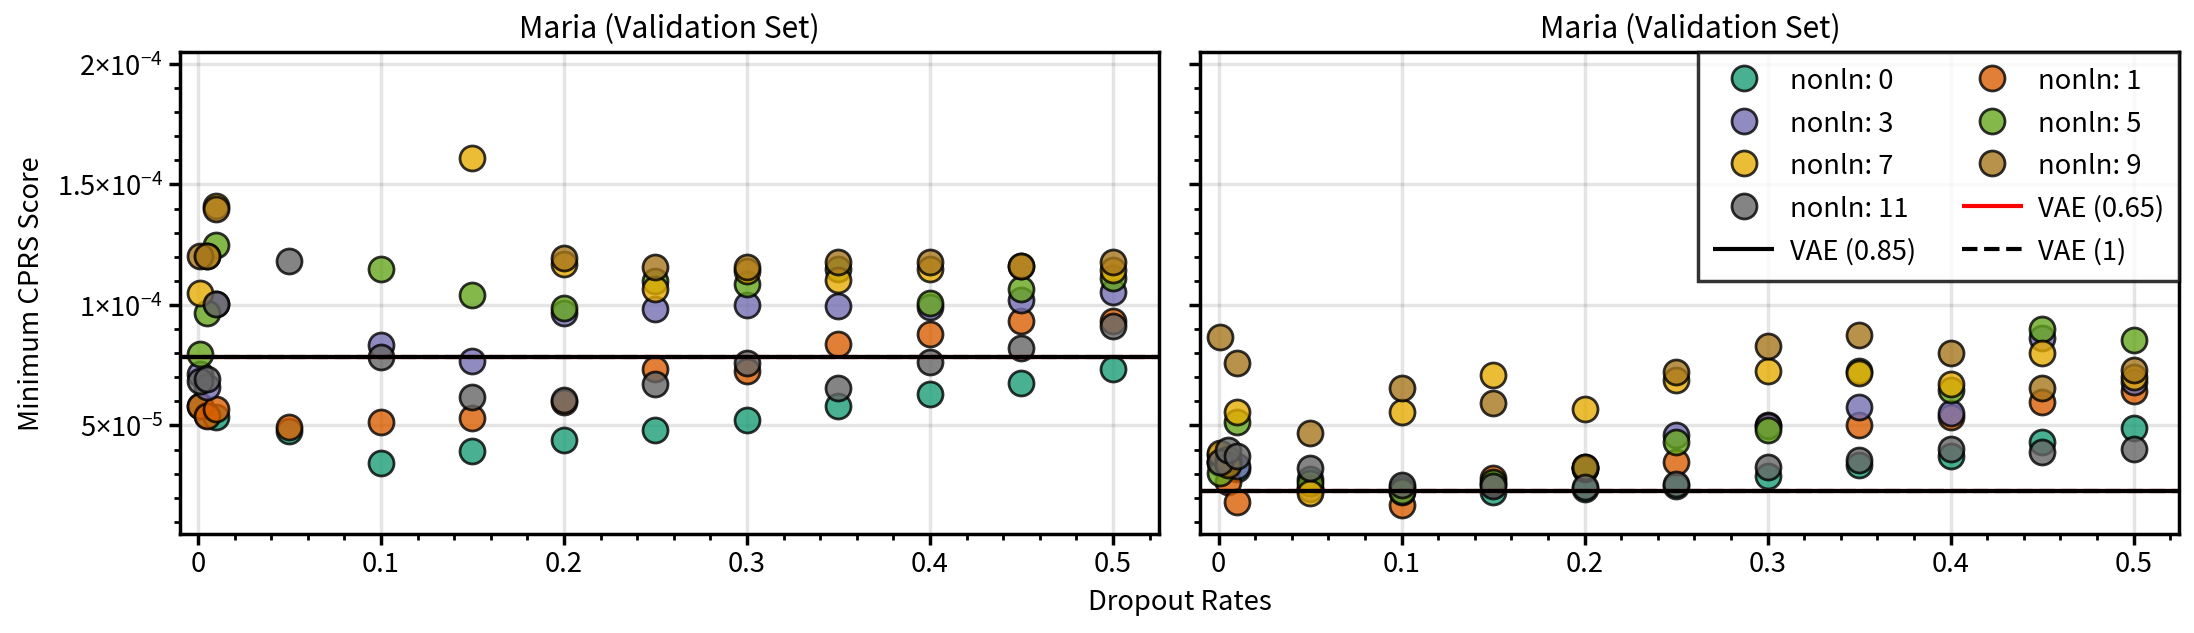

In [19]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.895,refaspect=2.031)
for ind,obj in enumerate([0,1,3,5,7,9,11]):#,5,7,9,11]):
    axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2vals'] for i in range(3)])) for obj in list(crps_store[obj].values())],lw=0,label='nonln: '+str(obj),marker='o',mfc=color1[ind],
                mew=1,mec='k',markersize=9,alpha=0.8)

#axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.45])])),color='r',ls='--',label='VAE (0.45)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.65])])),color='r',label='VAE (0.65)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.85])])),color='k',label='VAE (0.85)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.95])])),color='k',ls='--',label='VAE (1)')

for ind,obj in enumerate([0,1,3,5,7,9,11]):#,1,3]):#,5,7,9,11]):
    axs[1].plot(droprates,[np.nanmin(read_and_proc.flatten([obj[i]['r2vals'] for i in range(3)])) for obj in list(crps_store[obj].values())],lw=0,label='nonln: '+str(obj),marker='o',mfc=color1[ind],
                mew=1,mec='k',markersize=9,alpha=0.8)

#axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.45])])),color='r',ls='--',label='VAE (0.45)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.65])])),color='r',label='VAE (0.65)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.85])])),color='k',label='VAE (0.85)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.95])])),color='k',ls='--',label='VAE (1)')
#axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2vals'] for i in range(3)])) for obj in list(crps_performance.values())],lw=0,label='Validation',marker='o',mfc='C1',mew=1,mec='k',markersize=9,alpha=0.8)
#axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2tests'] for i in range(3)])) for obj in list(crps_performance.values())],lw=0,label='Test',marker='o',mfc='C2',mew=1,mec='k',markersize=9,alpha=0.8)
axs[1].legend(loc=1,ncols=2)
axs.format(xlabel='Dropout Rates',ylabel='Minimum CPRS Score',title='Maria (Validation Set)',ylim=[0.5e-5,20.5e-5],xlim=[-0.01,0.525])
axs[0].yaxis.set_major_formatter(plot.Formatter(('sci')))
plt.savefig('./figures/SI/SI_CRPS_maria_validate.png',dpi=600)
plt.show()

In [33]:
def report_vae_performance(storecc=None):
    train_median,train_min = [],[]
    valid_median,valid_min = [],[]
    test_median,test_min = [],[]

    for seed in seeds:
        train_median.append(np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (storecc[seed][0.75])])))
        valid_median.append(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (storecc[seed][0.75])])))
        test_median.append(np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (storecc[seed][0.75])])))
        
        train_min.append(np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (storecc[seed][0.75])])))
        valid_min.append(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (storecc[seed][0.75])])))
        test_min.append(np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (storecc[seed][0.75])])))
    return np.asarray(train_median),np.asarray(valid_median),np.asarray(test_median),np.asarray(train_min),np.asarray(valid_min),np.asarray(test_min)

In [34]:
train_median,valid_median,test_median,train_min,valid_min,test_min = report_vae_performance(seeds_store)

In [35]:
train_median.mean(),valid_median.mean(),test_median.mean()

(5.8843832987855266e-05, 7.783453266924587e-05, 5.2649285409737514e-05)

In [36]:
train_min.mean(),valid_min.mean(),test_min.mean()

(1.759399434163831e-05, 2.2811289637033994e-05, 1.3888594145606818e-05)

In [31]:
np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store[0][0.1])])),np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store[0][0.1])])),\
np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store[0][0.1])]))

(2.31841291722467e-05, 3.4610531059586635e-05, 2.5966385846045956e-05)

In [32]:
np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store[0][0.1])])),np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store[0][0.1])])),\
np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store[0][0.1])]))

(1.1579200950622723e-05, 2.3865065874766978e-05, 2.3249463017568074e-05)

## RMSE

In [46]:
train_median,valid_median,test_median,train_min,valid_min,test_min = report_vae_performance(seeds_store_rmse)

In [47]:
train_median.mean(),valid_median.mean(),test_median.mean()

(9.2726603076273e-05, 0.00011891374563616325, 7.316815681529609e-05)

In [48]:
train_min.mean(),valid_min.mean(),test_min.mean()

(3.7419215339246464e-05, 3.9342012201819765e-05, 2.2052245381259418e-05)

In [39]:
np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (rmse_store[0][0.1])])),np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (rmse_store[0][0.1])])),\
np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (rmse_store[0][0.1])]))

(4.565829352283054e-05, 6.220261449699872e-05, 3.838572053704612e-05)

In [40]:
np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (rmse_store[0][0.1])])),np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (rmse_store[0][0.1])])),\
np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (rmse_store[0][0.1])]))

(2.4608211307711606e-05, 3.566497499587162e-05, 3.540926027770363e-05)

## MAE

In [49]:
train_median,valid_median,test_median,train_min,valid_min,test_min = report_vae_performance(seeds_store_mae)

In [50]:
train_median.mean(),valid_median.mean(),test_median.mean()

(7.946444708762245e-05, 9.953562011929636e-05, 7.079063815965892e-05)

In [51]:
train_min.mean(),valid_min.mean(),test_min.mean()

(2.2128294438031562e-05, 3.196155387558975e-05, 1.7415585631747342e-05)

In [41]:
np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (mae_store[0][0.1])])),np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (mae_store[0][0.1])])),\
np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (mae_store[0][0.1])]))

(3.2110090863982716e-05, 4.852363932386259e-05, 3.5056699564421126e-05)

In [42]:
np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (mae_store[0][0.1])])),np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (mae_store[0][0.1])])),\
np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (mae_store[0][0.1])]))

(2.0341692492503262e-05, 3.1290299391710297e-05, 3.2206943184446346e-05)

## Spread-skill

In [52]:
import importlib,plotting
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
importlib.reload(plotting)

<module 'plotting' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/finalver/plotting.py'>

In [53]:
snum=2
coeff=0.75
splitno = 19
modelno = 0

def get_spread_skill_score_model(seeds_store=seeds_store,seeds=seeds,snum=snum,coeff=coeff,splitno=splitno,modelno=modelno,category='valid',meancat='meanvals'):
    aaaaaa = [np.percentile(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category],i) for i in np.arange(0,95,5)]
    
    hihihi = []
    hihihib = []

    ssRel = 0
    nPts = np.asarray(seeds_store[seeds[snum]][coeff][splitno]['truth'][modelno][category]).size
    for i in range(len(aaaaaa)-1):
        ytruth = np.asarray(seeds_store[seeds[snum]][coeff][splitno]['truth'][modelno][category])[np.where(np.logical_and(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]>aaaaaa[i],
                                                                                                                         seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]<aaaaaa[i+1]))]
        nPtsbin = ytruth.size
        ypred = np.asarray(seeds_store[seeds[snum]][coeff][splitno][meancat][modelno])[np.where(np.logical_and(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]>aaaaaa[i],
                                                                                                                  seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]<aaaaaa[i+1]))]
        spreadss = np.asarray(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category])[np.where(np.logical_and(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]>aaaaaa[i],
                                                                                                                             seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]<aaaaaa[i+1]))] 
        try:
            hihihi.append(np.sqrt(mean_squared_error(ytruth,ypred)))
            ssRel += (nPtsbin/nPts) * np.abs(np.sqrt(mean_squared_error(ytruth,ypred)) - np.mean(spreadss))
        except:
            hihihi.append(np.nan)
            ssRel += 0
    return {'spreadlim':aaaaaa,'error':hihihi,'ssRel':ssRel}

In [72]:
allsave = []
for snumz in tqdm(np.linspace(0,19,20)):
    tmpsave_1 = {}
    for coeffz in losscoeffs:
        tmpsave_2 = []
        for splitnoz in range(3):
            snumz=int(snumz)
            tempsNUM = len(seeds_store[seeds[snumz]][coeffz][splitnoz]['truth'])
            tmpsave_3 = [get_spread_skill_score_model(seeds_store=seeds_store,seeds=seeds,snum=snumz,coeff=coeffz,splitno=splitnoz,modelno=i,category='train',meancat='meantrains') for i in range(tempsNUM)]
            tmpsave_2.append(tmpsave_3)
        tmpsave_1[coeffz] = tmpsave_2
    allsave.append(tmpsave_1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [73]:
ssRels_array = np.zeros((3,9))
for i in (range(3)):
    for j in (range(9)):
        ssRels_array[i,j] = np.asarray([allsave[k][0.75][i][j]['ssRel'] for k in range(20)]).min()

#np.dstack(np.unravel_index(np.argsort(ssRels_array.ravel()), ssRels_array.shape))

In [74]:
np.nanmedian(ssRels_array),np.nanmin(ssRels_array)

(3.505829397181646e-05, 5.8777780802549975e-06)

In [75]:
testst = plotting.spread_error_diagram([0,10,20,30,40,50,60,70,80,90,100],'train',crps_store[0],droprates).get_allcriteria()
testst_flatten = plotting.spread_error_diagram([0,10,20,30,40,50,60,70,80,90,100],'train',crps_store[0],droprates).get_criteria_flatten() #[70,74,78,82,86,90,94,98,100]
curves_models,ssrels = plotting.spread_error_diagram([0,10,20,30,40,50,60,70,80,90,100],'train',crps_store[0],droprates).get_rmse_curve(testst_flatten)
ssrats = plotting.spread_error_diagram([0,10,20,30,40,50,60,70,80,90,100],'train',crps_store[0],droprates).get_ssrat()

In [76]:
np.nanmedian(np.asarray(ssrels[8])),np.nanmin(np.asarray(ssrels[8]))

(1.6178235575640487e-05, 3.5900371519733913e-06)

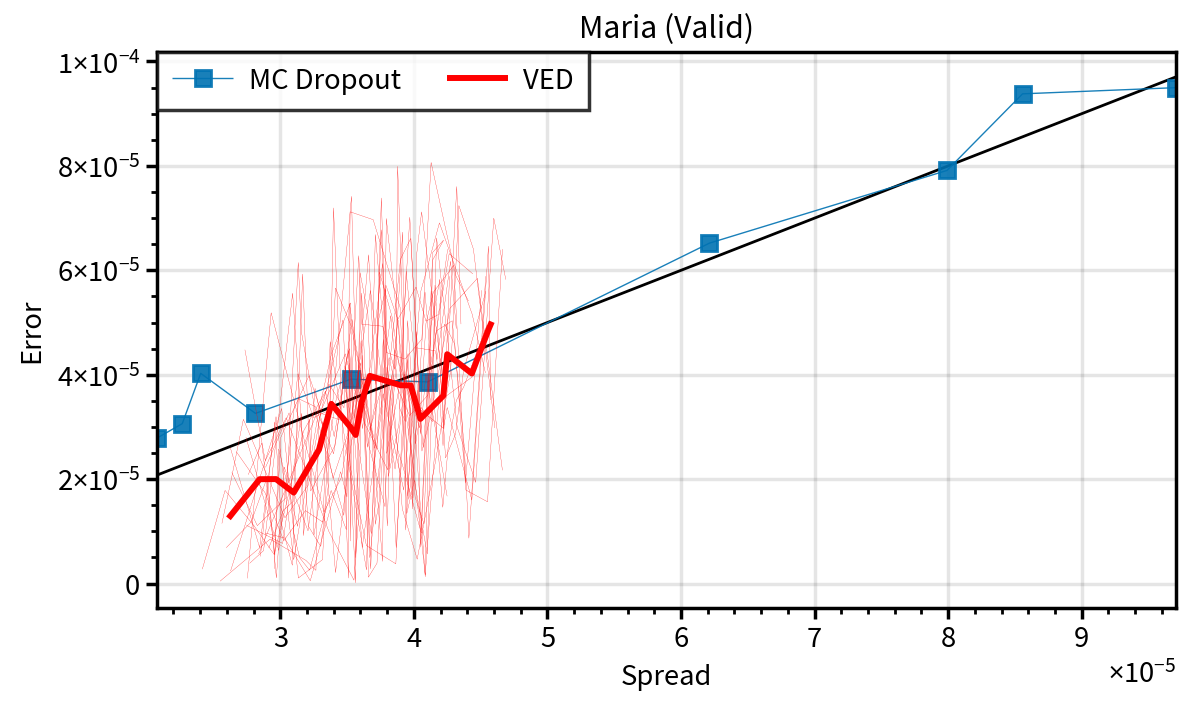

In [28]:
ssrelminindex,ssrelminindex_vae = 8,1
dropr,valsplit2,modelnum2 = ssrelminindex,np.asarray([np.asarray(obj).min() for obj in ssrels[ssrelminindex]]).argmin(),np.asarray(ssrels[ssrelminindex][np.asarray([np.asarray(obj).min() for obj in ssrels[ssrelminindex]]).argmin()]).argmin()
#dropr_vae,valsplit2_vae,modelnum2_vae = ssrelminindex_vae,np.asarray([np.asarray(obj).min() for obj in ssrels_vae[ssrelminindex_vae]]).argmin(),\
#np.asarray(ssrels_vae[ssrelminindex_vae][np.asarray([np.asarray(obj).min() for obj in ssrels_vae[ssrelminindex_vae]]).argmin()]).argmin()

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=5.095,refaspect=1.831,sharey=3)
axs[0].plot(testst_flatten[dropr][valsplit2][1:],testst_flatten[dropr][valsplit2][1:],color='k',lw=1)
curvefin = curves_models[dropr][valsplit2]
#plt.plot(testst_flatten[dropr][valsplit2][1:],curvefin[modelnum2],marker='s',lw=0.5,label=i,alpha=0.9)
axs[0].plot(testst_flatten[dropr][valsplit2][1:],curves_models[dropr][valsplit2][modelnum2],marker='s',lw=0.5,label='MC Dropout',alpha=0.9,)

hihihi = []
for snumz in np.linspace(0,19,20):
    newX = np.asarray(allsave[int(snumz)][0.65][1][6]['spreadlim'][1:])[~np.isnan(allsave[int(snumz)][0.65][1][6]['error'])]
    newY = np.asarray(allsave[int(snumz)][0.65][1][6]['error'])[~np.isnan(allsave[int(snumz)][0.65][1][6]['error'])]
    axs[0].plot(newX,newY,lw=0.095,color='r')
    hihihi.append(newY)
axs[0].plot(newX,np.mean(np.asarray(hihihi),axis=0),lw=2.15,color='r',label='VED')
#plt.plot(testst_flatten_vae[0][valsplit2_vae][1:],testst_flatten_vae[0][valsplit2_vae][1:],color='k',lw=1)
#axs[0].plot(testst_flatten_vae[dropr_vae][valsplit2_vae][1:],curves_models_vae[dropr_vae][valsplit2_vae][modelnum2_vae],marker='s',lw=0.5,label='VAE',alpha=0.9,)
axs[0].format(xlabel='Spread',ylabel='Error',title='Maria (Valid)')
axs[0].yaxis.set_major_formatter(plot.Formatter(('sci')))
plt.legend(loc=1)
plt.savefig('./figures/SI/SI_spreadskill_compare_maria_VED_MCDropout.png',dpi=600)
plt.show()

In [24]:
class analysis_patterns:
    def __init__(self,bestdropout_index=7,dropout_rates=None):
        self.bestdropout_index=bestdropout_index
        self.dropout_rates=dropout_rates
        
    def _get_best_model(self,crps_performance=None,numsplit=40):
        performances = [(([obj[i]['r2vals'] for i in range(numsplit)])) for obj in list(crps_performance.values())][self.bestdropout_index]
        storems = {}
        for i in range(len(performances[0])):
            storems[i] = ([performances[j][i] for j in range(len(performances))])
            
        best_dropout = self.dropout_rates[self.bestdropout_index]
        modelnum = np.asarray([np.mean(np.asarray(storems[key])) for key in storems.keys()]).argmin()
        valsplit = np.asarray(storems[modelnum]).argmin()
        try:
            bestmodel = crps_performance[best_dropout][int(valsplit)]['models'][int(modelnum)][0]
        except:
            bestmodel = crps_performance[best_dropout][int(valsplit)]['models'][int(modelnum)]
        return bestmodel,best_dropout,modelnum,valsplit,storems
    
    def new_structure(self,X_totrain=None,bestmodel=None,TYPE='LW',varINDX=[-40,-20]):
        LW,SW = (np.asarray(X_totrain)[:,varINDX[0]:varINDX[1]]),(np.asarray(X_totrain)[:,varINDX[1]:])
        store = []
        for i in range(np.abs(varINDX[1])):
            if TYPE=='LW':
                term1 = benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()[i]#benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0]*benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()[i]
                sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()/np.std(LW,axis=0))**2))
                term2 = (np.std(LW[:,i])*sumss)
                store.append(np.sign(benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0])*term1/term2)
            elif TYPE=='SW':
                term1 = benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()[i]#benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[1]*benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()[i]
                sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()/np.std(SW,axis=0))**2))
                term2 = (np.std(SW[:,i])*sumss)
                store.append(np.sign(benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[1])*term1/term2)
        return store
    
    def new_structure_vae(self,X_totrain=None,bestmodel=None,TYPE='LW',varINDX=[-40,-20]):
        LW,SW = (np.asarray(X_totrain)[:,varINDX[0]:varINDX[1]]),(np.asarray(X_totrain)[:,varINDX[1]:])
        store = []
        for i in range(np.abs(varINDX[1])):
            if TYPE=='LW':
                term1 = benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()[i]#benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0]*benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()[i]
                sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()/np.std(LW,axis=0))**2))
                term2 = (np.std(LW[:,i])*sumss)
                store.append(np.sign(benchmark.model_outweights_all(bestmodel)[0][-4][0].detach().numpy()[0])*term1/term2)
            elif TYPE=='SW':
                term1 = benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()[i]#benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[1]*benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()[i]
                sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()/np.std(SW,axis=0))**2))
                term2 = (np.std(SW[:,i])*sumss)
                store.append(np.sign(benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0])*term1/term2)
            elif TYPE=='LW_logvar':
                term1 = benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()[i]#benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0]*benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()[i]
                sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()/np.std(LW,axis=0))**2))
                term2 = (np.std(LW[:,i])*sumss)
                store.append(np.sign(benchmark.model_outweights_all(bestmodel)[0][-4][0].detach().numpy()[0])*term1/term2)                
        return store
    
    def new_coeff(self,X_totrain=None,bestmodel=None,TYPE='LW',varINDX=[-40,-20]):
        LW,SW = (np.asarray(X_totrain)[:,varINDX[0]:varINDX[1]]),(np.asarray(X_totrain)[:,varINDX[1]:])
        if TYPE=='LW':
            sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()/np.std(LW,axis=0))**2))
            store = (np.abs(benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0])*sumss)
        elif TYPE=='SW':
            sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()/np.std(SW,axis=0))**2))
            store = (np.abs(benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[1])*sumss)
        return store
    
    def new_coeff_vae(self,X_totrain=None,bestmodel=None,TYPE='LW',varINDX=[-40,-20]):
        LW,SW = (np.asarray(X_totrain)[:,varINDX[0]:varINDX[1]]),(np.asarray(X_totrain)[:,varINDX[1]:])
        if TYPE=='LW':
            sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()/np.std(LW,axis=0))**2))
            store = (np.abs(benchmark.model_outweights_all(bestmodel)[0][-4][0].detach().numpy()[0])*sumss)
        elif TYPE=='SW':
            sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()/np.std(SW,axis=0))**2))
            store = (np.abs(benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0])*sumss)
        return store
    
    def new_b(self,X_totrain=None,bestmodel=None,varINDX=[-40,-20]):
        LW,SW = (np.asarray(X_totrain)[:,varINDX[0]:varINDX[1]]),(np.asarray(X_totrain)[:,varINDX[1]:])
        store = []
        b2 = float(benchmark.model_outweights_all(bestmodel)[0][-1][0].detach().numpy())
        b1lw = float(benchmark.model_outweights_all(bestmodel)[0][1][0].detach().numpy())
        a2lw = benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0]
        b1sw = float(benchmark.model_outweights_all(bestmodel)[0][3][0].detach().numpy())
        a2sw = benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[1]
                
        sumss_lw = np.sum((benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()/np.std(LW,axis=0)*np.mean(LW,axis=0)))
        sumss_sw = np.sum((benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()/np.std(SW,axis=0)*np.mean(SW,axis=0)))
            
        b = b2 + a2lw * (b1lw - sumss_lw) + a2sw * (b1sw - sumss_sw)
        return b
    
    def new_b_vae(self,X_totrain=None,bestmodel=None,varINDX=[-40,-20]):
        LW,SW = (np.asarray(X_totrain)[:,varINDX[0]:varINDX[1]]),(np.asarray(X_totrain)[:,varINDX[1]:])
        store = []
        b2 = float(benchmark.model_outweights_all(bestmodel)[0][-1][0].detach().numpy())+float(benchmark.model_outweights_all(bestmodel)[0][-3][0].detach().numpy())
        b1lw = float(benchmark.model_outweights_all(bestmodel)[0][1][0].detach().numpy())
        a2lw = benchmark.model_outweights_all(bestmodel)[0][-4][0].detach().numpy()[0]
        b1sw = float(benchmark.model_outweights_all(bestmodel)[0][3][0].detach().numpy())
        a2sw = benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0]
                
        sumss_lw = np.sum((benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()/np.std(LW,axis=0)*np.mean(LW,axis=0)))
        sumss_sw = np.sum((benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()/np.std(SW,axis=0)*np.mean(SW,axis=0)))
            
        b = b2 + a2lw * (b1lw - sumss_lw) + a2sw * (b1sw - sumss_sw)
        return 

In [11]:
bestmodel = seeds_store[seeds[0]][0.85][1]['models'][6]
ALW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[1]['train'][0],bestmodel,'LW',[-20,-10])
ASW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[1]['train'][0],bestmodel,'SW',[-20,-10])
B = benchmark.analysis_patterns(None,None).new_b_vae(store_notensor[1]['train'][0],bestmodel,[-20,-10])

pcalw,pcasw = read_and_proc.depickle('./maria_store/pca/lw/'+str(1)+'/PCA3D_corr.pkg'),read_and_proc.depickle('./maria_store/pca/sw/'+str(1)+'/PCA3D_corr.pkg')
fl = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[1]['train'][0],bestmodel,'LW',[-20,-10])
fl_logvar = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[1]['train'][0],bestmodel,'LW_logvar',[-20,-10])
flsw = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[1]['train'][0],bestmodel,'SW',[-20,-10])
flas = np.squeeze(np.dot(fl,pcalw['lw'].components_[:10,:])).reshape(39,360,200)
flas_logvar = np.squeeze(np.dot(fl_logvar,pcalw['lw'].components_[:10,:])).reshape(39,360,200)
#flas_sw = np.squeeze(np.dot(flsw,pcasw['sw'].components_[:20,:])).reshape(10,360,208)

## Prediction

In [57]:
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 14.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

valsplit=1
accesscode = 0.85
modelnum=1
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=5.095,refaspect=1.831,share=1)
axs[0].plot(store_notensor[valsplit]['train'][1],label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
axs[0].plot(seeds_store[seeds[0]][accesscode][int(valsplit)]['meantrains'][int(modelnum)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])

allpreds = seeds_store[seeds[0]][accesscode][int(valsplit)]['alltrains'][int(modelnum)]
for pred in allpreds:
    axs[0].plot(pred,c='r',lw=0.35,alpha=0.05)
axs[0].legend(loc=4,ncols=1,prop={'size':7})
#r2_scoress = r2_score(store_notensor[valsplit]['train'][1],r2_performance[accesscode][int(valsplit)]['meantrains'][int(modelnum)])
axs[0].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Train')

axs[1].plot(store_notensor[valsplit]['valid'][1],label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
axs[1].plot(seeds_store[seeds[0]][accesscode][int(valsplit)]['meanvals'][int(modelnum)],label='Mean Prediction (VAE; 50 Trials)',c='r',lw=2.5)#79:132])
axs[1].plot(crps_store[0][0.1][int(valsplit)]['meanvals'][int(modelnum)],c='b',lw=2.5,label='Mean Prediction (MC_Dropout; 50 Trials)')
allpreds = seeds_store[seeds[0]][accesscode][int(valsplit)]['allvals'][int(modelnum)]
for pred in allpreds:
    axs[1].plot(pred,c='r',lw=0.35,alpha=0.05)
axs[1].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: NCRF96')#,rtitle='Optimal Longwave')
axs[1].legend(loc=1,ncols=1)

axs[2].plot(store_notensor[valsplit]['test'][1],label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
axs[2].plot(seeds_store[seeds[0]][accesscode][int(valsplit)]['meantests'][int(modelnum)],label='Mean Prediction (VAE; 50 Trials)',c='r',lw=2.5)#79:132])
axs[2].plot(crps_store[0][0.1][int(valsplit)]['meantests'][int(modelnum)],c='b',lw=2.5,label='Mean Prediction (MC_Dropout; 50 Trials)')#79:132])
allpreds = seeds_store[seeds[0]][accesscode][int(valsplit)]['alltests'][int(modelnum)]
for pred in allpreds:
    axs[2].plot(pred,c='r',lw=0.35,alpha=0.05)
axs[2].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: NCRF36')#,rtitle='Optimal Longwave')

#axs[3].plot(store_notensor[valsplit]['test'][1],c='k',lw=2.5)
#axs[3].plot(seeds_store[seeds[0]][accesscode][int(valsplit)]['meantests'][int(modelnum)],label='Mean Prediction (VAE; 50 Trials)',c='r',lw=2.5)

#allpres = seeds_store[seeds[0]][accesscode][int(valsplit)]['alltests'][int(modelnum)]
#for allpre in allpres:
#    axs[3].plot(allpre,label='Mean Prediction (50 Trials)',c='r',lw=0.15,alpha=0.22)
#axs[3].format(xlim=[0,82],title='Member 11') #xlim=[82,145]
plt.savefig('./figures/paper_fig2_si_maria_revised.png',dpi=600)
plt.show()

In [27]:
bestdrop_indx = 5#np.abs(np.asarray(droprates)-0.2).argmin()
bestmodel,best_dropout,modelnum,valsplit,storems = benchmark.analysis_patterns(bestdrop_indx,droprates)._get_best_model(crps_store[0],numsplit)
pcalw,pcasw = read_and_proc.depickle('./maria_store/pca/lw/'+str(valsplit)+'/PCA3D_corr.pkg'),read_and_proc.depickle('./maria_store/pca/sw/'+str(valsplit)+'/PCA3D_corr.pkg')
fl = benchmark.analysis_patterns(bestdrop_indx,droprates).new_structure(store_notensor[valsplit]['train'][0],bestmodel,'LW',[-20,-10])
flsw = benchmark.analysis_patterns(bestdrop_indx,droprates).new_structure(store_notensor[valsplit]['train'][0],bestmodel,'SW',[-20,-10])
flas = np.squeeze(np.dot(fl,pcalw['lw'].components_[:10,:])).reshape(39,360,200)
flas_sw = np.squeeze(np.dot(flsw,pcasw['sw'].components_[:10,:])).reshape(39,360,200)

ALW = benchmark.analysis_patterns(bestdrop_indx,droprates).new_coeff(store_notensor[valsplit]['train'][0],bestmodel,'LW',[-20,-10])
ASW = benchmark.analysis_patterns(bestdrop_indx,droprates).new_coeff(store_notensor[valsplit]['train'][0],bestmodel,'SW',[-20,-10])
B = benchmark.analysis_patterns(bestdrop_indx,droprates).new_b(store_notensor[valsplit]['train'][0],bestmodel,[-20,-10])

In [12]:
from sklearn.metrics import r2_score
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 16.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

valsplit=1
accesscode = 0.85
modelnum=1
r2_performance = seeds_store[seeds[0]]
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=8.095,refaspect=1.831,share=3)
axs[0].plot(np.linspace(15,15+96-1,96),store_notensor[valsplit]['train'][1][0:96],label=f'Target (CTRL)',c='tab:purple',lw=2.5)#79:132])
axs[0].plot(np.linspace(15,15+96-1,96),r2_performance[accesscode][int(valsplit)]['meantrains'][int(modelnum)][0:96],label='CTRL Prediction (50 Trials)',c='tab:purple',lw=2.5,ls='--')#79:132])

allpreds = r2_performance[accesscode][int(valsplit)]['alltrains'][int(modelnum)]
for pred in allpreds:
    axs[0].plot(np.linspace(16,16+96-1,96),pred[0:96],c='tab:purple',lw=0.25,alpha=0.075)
r2_scoress = r2_score(store_notensor[valsplit]['train'][1],r2_performance[accesscode][int(valsplit)]['meantrains'][int(modelnum)])
axs[0].format(xlabel='Time [Hr]',ylabel='Max. Surf. Winds Inten. Rates (m s$^{-2}$)',ylim=[-0.00018,0.0004],xlim=[10,118-15])

axs[0].plot(np.linspace((25),(25)+96-1,96),store_notensor[valsplit]['test'][1],label=f'Target (NCRF36)',c='tab:red',lw=2.5)#79:132])
axs[0].plot(np.linspace((25),(25)+96-1,96),r2_performance[accesscode][int(valsplit)]['meantests'][int(modelnum)],label='NCRF36 Prediction (50 Trials)',c='tab:red',lw=2.5,ls='--')#79:132])
allpreds = r2_performance[accesscode][int(valsplit)]['alltests'][int(modelnum)]
for pred in allpreds:
    axs[0].plot(np.linspace((25),(25)+96-1,96),pred,c='tab:red',lw=0.25,alpha=0.075)
    
axs[0].plot(np.linspace((49),(49)+96-24-1,96-24),store_notensor[valsplit]['train'][1][(118-24):(118-24)+(96-24)],label=f'Target (NCRF60)',c='tab:blue',lw=2.5)#79:132])
axs[0].plot(np.linspace((49),(49)+96-24-1,96-24),r2_performance[accesscode][int(valsplit)]['meantrains'][int(modelnum)][(118-24):(118-24)+(96-24)],label='NCRF60 Prediction (50 Trials)',c='tab:blue',lw=2.5,ls='--')#79:132])
allpreds = r2_performance[accesscode][int(valsplit)]['alltrains'][int(modelnum)]
for pred in allpreds:
    axs[0].plot(np.linspace((49),(49)+96-24-1,96-24),pred[(118-24):(118-24)+(96-24)],c='tab:blue',lw=0.15,alpha=0.075)
axs[0].legend(loc=2,ncols=2,prop={'size':13})


axs[1].plot(np.linspace(15,15+96-1,96),ALW*np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-20:-10],fl)[0:96],label='CTRL: Longwave',c='tab:purple',lw=2.5)#79:132])
axs[1].plot(np.linspace(15,15+96-1,96),ASW*np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-10:],flsw)[0:96],label='CTRL: Shortwave',c='tab:purple',lw=2.5,ls='--')
axs[1].plot(np.linspace((25),(25)+96-1,96),ALW*np.dot(np.asarray(store_notensor[valsplit]['test'][0])[:,-20:-10],fl),label='NCRF36: Longwave',c='tab:red',lw=2.5)#79:132])
axs[1].plot(np.linspace((25),(25)+96-1,96),ASW*np.dot(np.asarray(store_notensor[valsplit]['test'][0])[:,-10:],flsw),label='NCRF36: Shortwave',c='tab:red',lw=2.5,ls='--')
axs[1].plot(np.linspace((49),(49)+96-24-1,96-24),ALW*np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-20:-10],fl)[(118-24):(118-24)+(96-24)],label='NCRF60: Longwave',c='tab:blue',lw=2.5)#79:132])
axs[1].plot(np.linspace((49),(49)+96-24-1,96-24),ASW*np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-10:],flsw)[(118-24):(118-24)+(96-24)],label='NCRF60: Shortwave',c='tab:blue',lw=2.5,ls='--')

axs[1].axhline(y=B,label='Persistence',c='k',lw=1.5,ls='--')
axs[1].legend(loc=2,ncols=2)
axs[1].format(xlabel='Time Samples',ylabel=r'Max. Surf. Winds Inten. Rates (m s$^{-2}$)',ylim=[-0.00018,0.0004],xlim=[10,118-15])
#axs[1].plot(store_notensor[valsplit]['valid'][1],label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
#axs[1].plot(r2_performance[accesscode][int(valsplit)]['meanvals'][int(modelnum)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
#allpreds = r2_performance[accesscode][int(valsplit)]['allvals'][int(modelnum)]
#for pred in allpreds:
#    axs[1].plot(pred,c='r',lw=0.35,alpha=0.075)
#r2_scoress = r2_score(y_toval,r2_performance[accesscode][int(valsplit)]['meanvals'][int(modelnum)])
#axs[1].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='NCRF_96HR',rtitle=f'Best Model: Validation')#,rtitle='Optimal Longwave')
#plt.savefig('../analysis/pic/climateinfo/MCdropout_testskill_revised.png',dpi=600)

#axs[2].plot(store_notensor[valsplit]['test'][1],label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
#axs[2].plot(r2_performance[accesscode][int(valsplit)]['meantests'][int(modelnum)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
#allpreds = r2_performance[accesscode][int(valsplit)]['alltests'][int(modelnum)]
#for pred in allpreds:
#    axs[2].plot(pred,c='r',lw=0.35,alpha=0.075)
#r2_scoress = r2_score(y_totest,r2_performance[accesscode][int(valsplit)]['meantests'][int(modelnum)])
#axs[2].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='NCRF_36HR',rtitle=f'Best Model: Test')#,rtitle='Optimal Longwave')

#axs[3].plot(store_notensor[valsplit]['test'][1],c='k',lw=2.5)
#axs[3].plot(r2_performance[accesscode][int(valsplit)]['meantests'][int(modelnum)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)

#allpres = r2_performance[accesscode][int(valsplit)]['alltests'][int(modelnum)]
#for allpre in allpres:
#    axs[3].plot(allpre,label='Mean Prediction (50 Trials)',c='r',lw=0.15,alpha=0.22)
#axs[3].format(xlim=[82,145],title='Member 18')
plt.savefig('./figures/paper_fig2_maria_revised_ved.png',dpi=600)
plt.show()

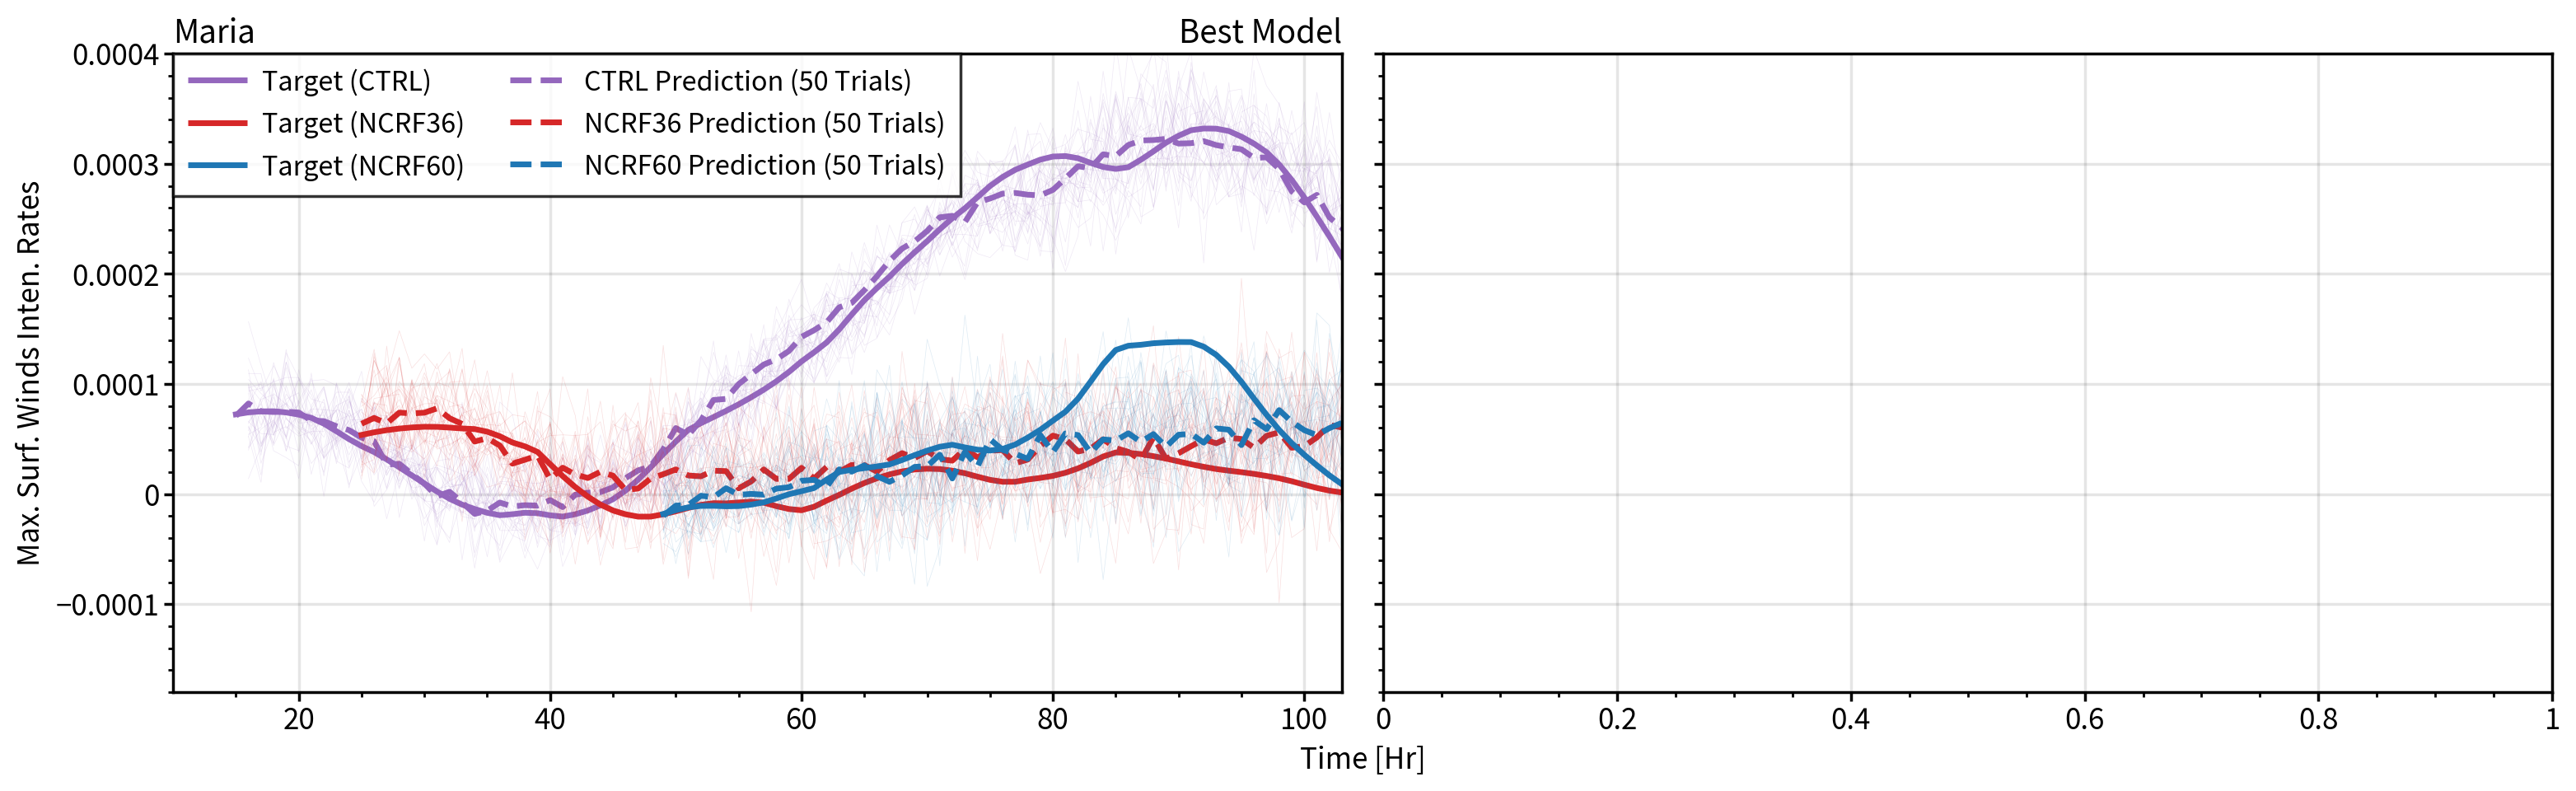

In [29]:
from sklearn.metrics import r2_score
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 14.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

r2_performance = seeds_store[seeds[0]]
accesscode = 0.85
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=7.095,refaspect=1.831,share=3)
axs[0].plot(np.linspace(15,15+96-1,96),store_notensor[valsplit]['train'][1][0:96],label=f'Target (CTRL)',c='tab:purple',lw=2.5)#79:132])
axs[0].plot(np.linspace(15,15+96-1,96),seeds_store[seeds[0]][accesscode][int(valsplit)]['meantrains'][int(modelnum)][0:96],label='CTRL Prediction (50 Trials)',c='tab:purple',lw=2.5,ls='--')#79:132])

allpreds = r2_performance[accesscode][int(valsplit)]['alltrains'][int(modelnum)]
for pred in allpreds:
    axs[0].plot(np.linspace(16,16+96-1,96),pred[0:96],c='tab:purple',lw=0.25,alpha=0.15)
r2_scoress = r2_score(store_notensor[valsplit]['train'][1],r2_performance[accesscode][int(valsplit)]['meantrains'][int(modelnum)])
axs[0].format(xlabel='Time [Hr]',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Maria',rtitle=f'Best Model',ylim=[-0.00018,0.0004],xlim=[10,118-15])

axs[0].plot(np.linspace((25),(25)+96-1,96),store_notensor[valsplit]['test'][1],label=f'Target (NCRF36)',c='tab:red',lw=2.5)#79:132])
axs[0].plot(np.linspace((25),(25)+96-1,96),seeds_store[seeds[0]][accesscode][int(valsplit)]['meantests'][int(modelnum)],label='NCRF36 Prediction (50 Trials)',c='tab:red',lw=2.5,ls='--')#79:132])
allpreds = r2_performance[accesscode][int(valsplit)]['alltests'][int(modelnum)]
for pred in allpreds:
    axs[0].plot(np.linspace((25),(25)+96-1,96),pred,c='tab:red',lw=0.25,alpha=0.15)
    
axs[0].plot(np.linspace((49),(49)+96-24-1,96-24),store_notensor[valsplit]['train'][1][(118-24):(118-24)+(96-24)],label=f'Target (NCRF60)',c='tab:blue',lw=2.5)#79:132])
axs[0].plot(np.linspace((49),(49)+96-24-1,96-24),seeds_store[seeds[0]][accesscode][int(valsplit)]['meantrains'][int(modelnum)][(118-24):(118-24)+(96-24)],label='NCRF60 Prediction (50 Trials)',c='tab:blue',lw=2.5,ls='--')#79:132])
allpreds = r2_performance[accesscode][int(valsplit)]['alltrains'][int(modelnum)]
for pred in allpreds:
    axs[0].plot(np.linspace((49),(49)+96-24-1,96-24),pred[(118-24):(118-24)+(96-24)],c='tab:blue',lw=0.25,alpha=0.15)
axs[0].legend(loc=2,ncols=2,prop={'size':13})


#axs[1].plot(np.linspace(15,15+96-1,96),ALW*np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-20:-10],fl)[0:96],label='CTRL: Longwave',c='tab:purple',lw=2.5)#79:132])
#axs[1].plot(np.linspace(15,15+96-1,96),ASW*np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-10:],flsw)[0:96],label='CTRL: Shortwave',c='tab:purple',lw=2.5,ls='--')
#axs[1].plot(np.linspace((25),(25)+96-1,96),ALW*np.dot(np.asarray(store_notensor[valsplit]['test'][0])[:,-20:-10],fl),label='NCRF36: Longwave',c='tab:red',lw=2.5)#79:132])
#axs[1].plot(np.linspace((25),(25)+96-1,96),ASW*np.dot(np.asarray(store_notensor[valsplit]['test'][0])[:,-10:],flsw),label='NCRF36: Shortwave',c='tab:red',lw=2.5,ls='--')
#axs[1].plot(np.linspace((49),(49)+96-24-1,96-24),ALW*np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-20:-10],fl)[(118-24):(118-24)+(96-24)],label='NCRF60: Longwave',c='tab:blue',lw=2.5)#79:132])
#axs[1].plot(np.linspace((49),(49)+96-24-1,96-24),ASW*np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-10:],flsw)[(118-24):(118-24)+(96-24)],label='NCRF60: Shortwave',c='tab:blue',lw=2.5,ls='--')

#axs[1].axhline(y=B,label='Persistence',c='k',lw=1.5,ls='--')
#axs[1].legend(loc=2,ncols=2)
#axs[1].format(xlabel='Time Samples',ylabel=r'Max. Surf. Winds Inten. Rates',ltitle='LW/SW',rtitle=f'Decomposition',ylim=[-0.00018,0.0004],xlim=[10,118-15])
#axs[1].plot(store_notensor[valsplit]['valid'][1],label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
#axs[1].plot(r2_performance[accesscode][int(valsplit)]['meanvals'][int(modelnum)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
plt.show()

In [17]:
#plt.plot(np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-20:-10],fl))
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=5.095,refaspect=1.831,share=1)
axs[0].plot(np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-20:-10],fl),label='Longwave',c='k',lw=2.5)#79:132])
axs[0].plot(np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-10:],flsw),label='Shortwave',c='r',lw=2.5)
axs[0].legend(loc=4,ncols=1)
axs[0].format(xlabel='Time Samples',ylabel=r'$PC_{Pi_{LW/SW}}$',ltitle='Maria',rtitle=f'Best Model: Train')

axs[1].plot(np.dot(np.asarray(store_notensor[valsplit]['valid'][0])[:,-20:-10],fl),label='Longwave',c='k',lw=2.5)#79:132])
axs[1].plot(np.dot(np.asarray(store_notensor[valsplit]['valid'][0])[:,-10:],flsw),label='Shortwave',c='r',lw=2.5)
#r2_scoress = r2_score(y_toval,r2_performance[accesscode][int(valsplit)]['meanvals'][int(modelnum)])
axs[1].format(xlabel='Time Samples',ylabel=r'$PC_{Pi_{LW/SW}}$',ltitle='NCRF_96HR',rtitle=f'Best Model: Validation')#,rtitle='Optimal Longwave')
#plt.savefig('../analysis/pic/climateinfo/MCdropout_testskill_revised.png',dpi=600)

axs[2].plot(np.dot(np.asarray(store_notensor[valsplit]['test'][0])[:,-20:-10],fl),label='Longwave',c='k',lw=2.5)#79:132])
axs[2].plot(np.dot(np.asarray(store_notensor[valsplit]['test'][0])[:,-10:],flsw),label='Shortwave',c='r',lw=2.5)
axs[2].format(xlabel='Time Samples',ylabel=r'$PC_{Pi_{LW/SW}}$',ltitle='NCRF_36HR',rtitle=f'Best Model: Test')#,rtitle='Optimal Longwave')
plt.savefig('./figures/paper_suppl_maria_PCs.png',dpi=600)
plt.show()

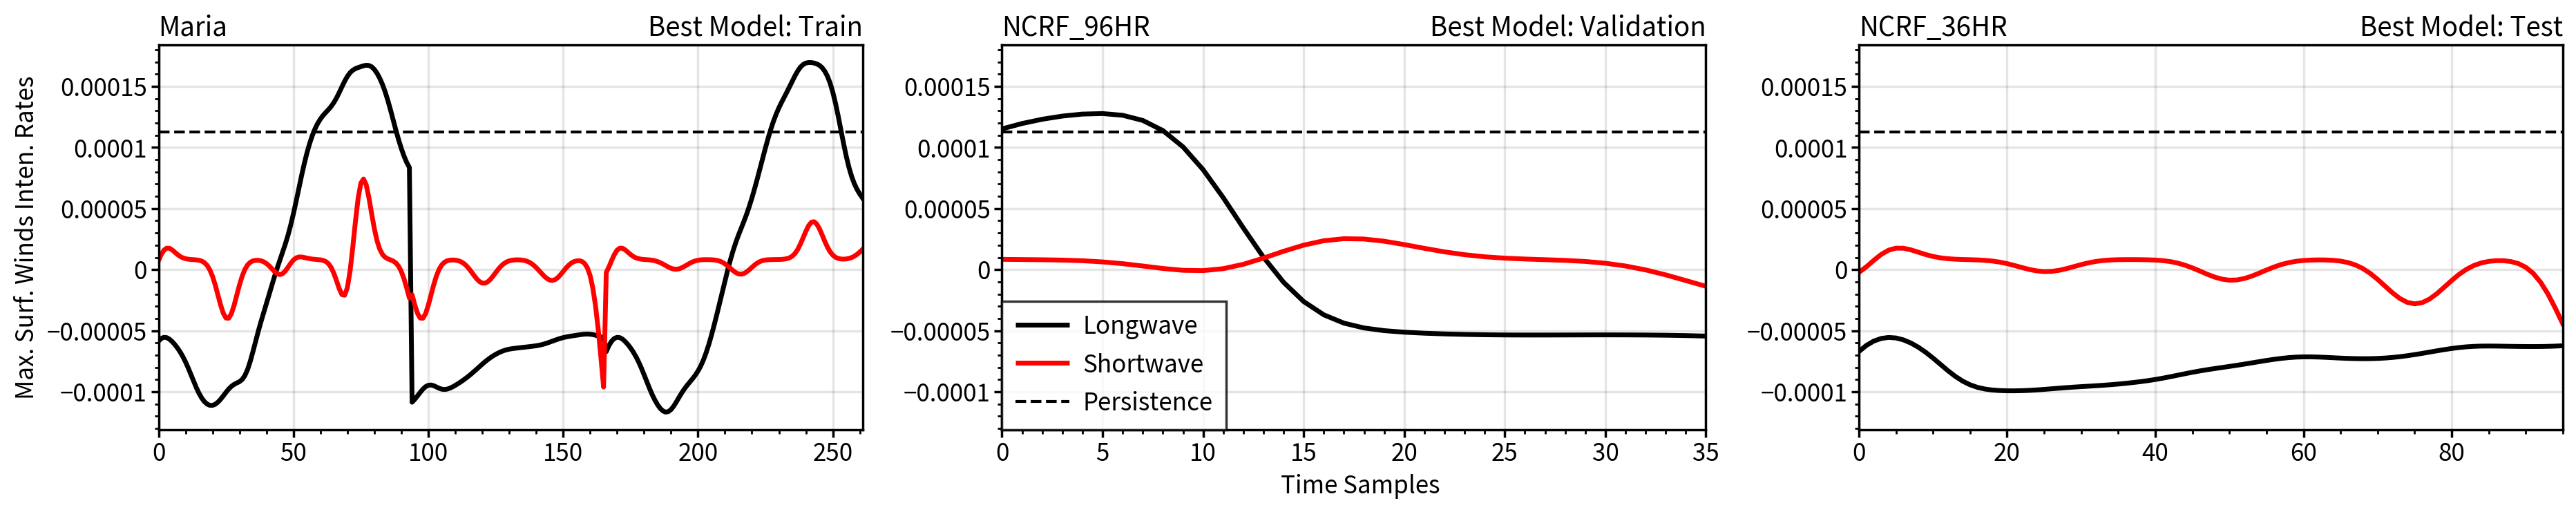

In [18]:
#plt.plot(np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-20:-10],fl))
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=5.095,refaspect=1.831,share=2)
axs[0].plot(ALW*np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-20:-10],fl),label='Longwave',c='k',lw=2.5)#79:132])
axs[0].plot(ASW*np.dot(np.asarray(store_notensor[valsplit]['train'][0])[:,-10:],flsw),label='Shortwave',c='r',lw=2.5)
axs[0].axhline(y=B,label='Persistence',c='k',lw=1.5,ls='--')
#axs[0].legend(loc=4,ncols=1)
axs[0].format(xlabel='Time Samples',ylabel=r'Max. Surf. Winds Inten. Rates',ltitle='Maria',rtitle=f'Best Model: Train')

axs[1].plot(ALW*np.dot(np.asarray(store_notensor[valsplit]['valid'][0])[:,-20:-10],fl),label='Longwave',c='k',lw=2.5)#79:132])
axs[1].plot(ASW*np.dot(np.asarray(store_notensor[valsplit]['valid'][0])[:,-10:],flsw),label='Shortwave',c='r',lw=2.5)
axs[1].axhline(y=B,label='Persistence',c='k',lw=1.5,ls='--')
#r2_scoress = r2_score(y_toval,r2_performance[accesscode][int(valsplit)]['meanvals'][int(modelnum)])
axs[1].legend(loc=0,ncols=1)
axs[1].format(xlabel='Time Samples',ylabel=r'Max. Surf. Winds Inten. Rates',ltitle='NCRF_96HR',rtitle=f'Best Model: Validation')#,rtitle='Optimal Longwave')
#plt.savefig('../analysis/pic/climateinfo/MCdropout_testskill_revised.png',dpi=600)

axs[2].plot(ALW*np.dot(np.asarray(store_notensor[valsplit]['test'][0])[:,-20:-10],fl),label='Longwave',c='k',lw=2.5)#79:132])
axs[2].plot(ASW*np.dot(np.asarray(store_notensor[valsplit]['test'][0])[:,-10:],flsw),label='Shortwave',c='r',lw=2.5)
axs[2].axhline(y=B,label='Persistence',c='k',lw=1.5,ls='--')
axs[2].format(xlabel='Time Samples',ylabel=r'Max. Surf. Winds Inten. Rates',ltitle='NCRF_36HR',rtitle=f'Best Model: Test')#,rtitle='Optimal Longwave')
plt.savefig('./figures/paper_suppl_maria_decomposed_inten.png',dpi=600)
plt.show()

## Structure

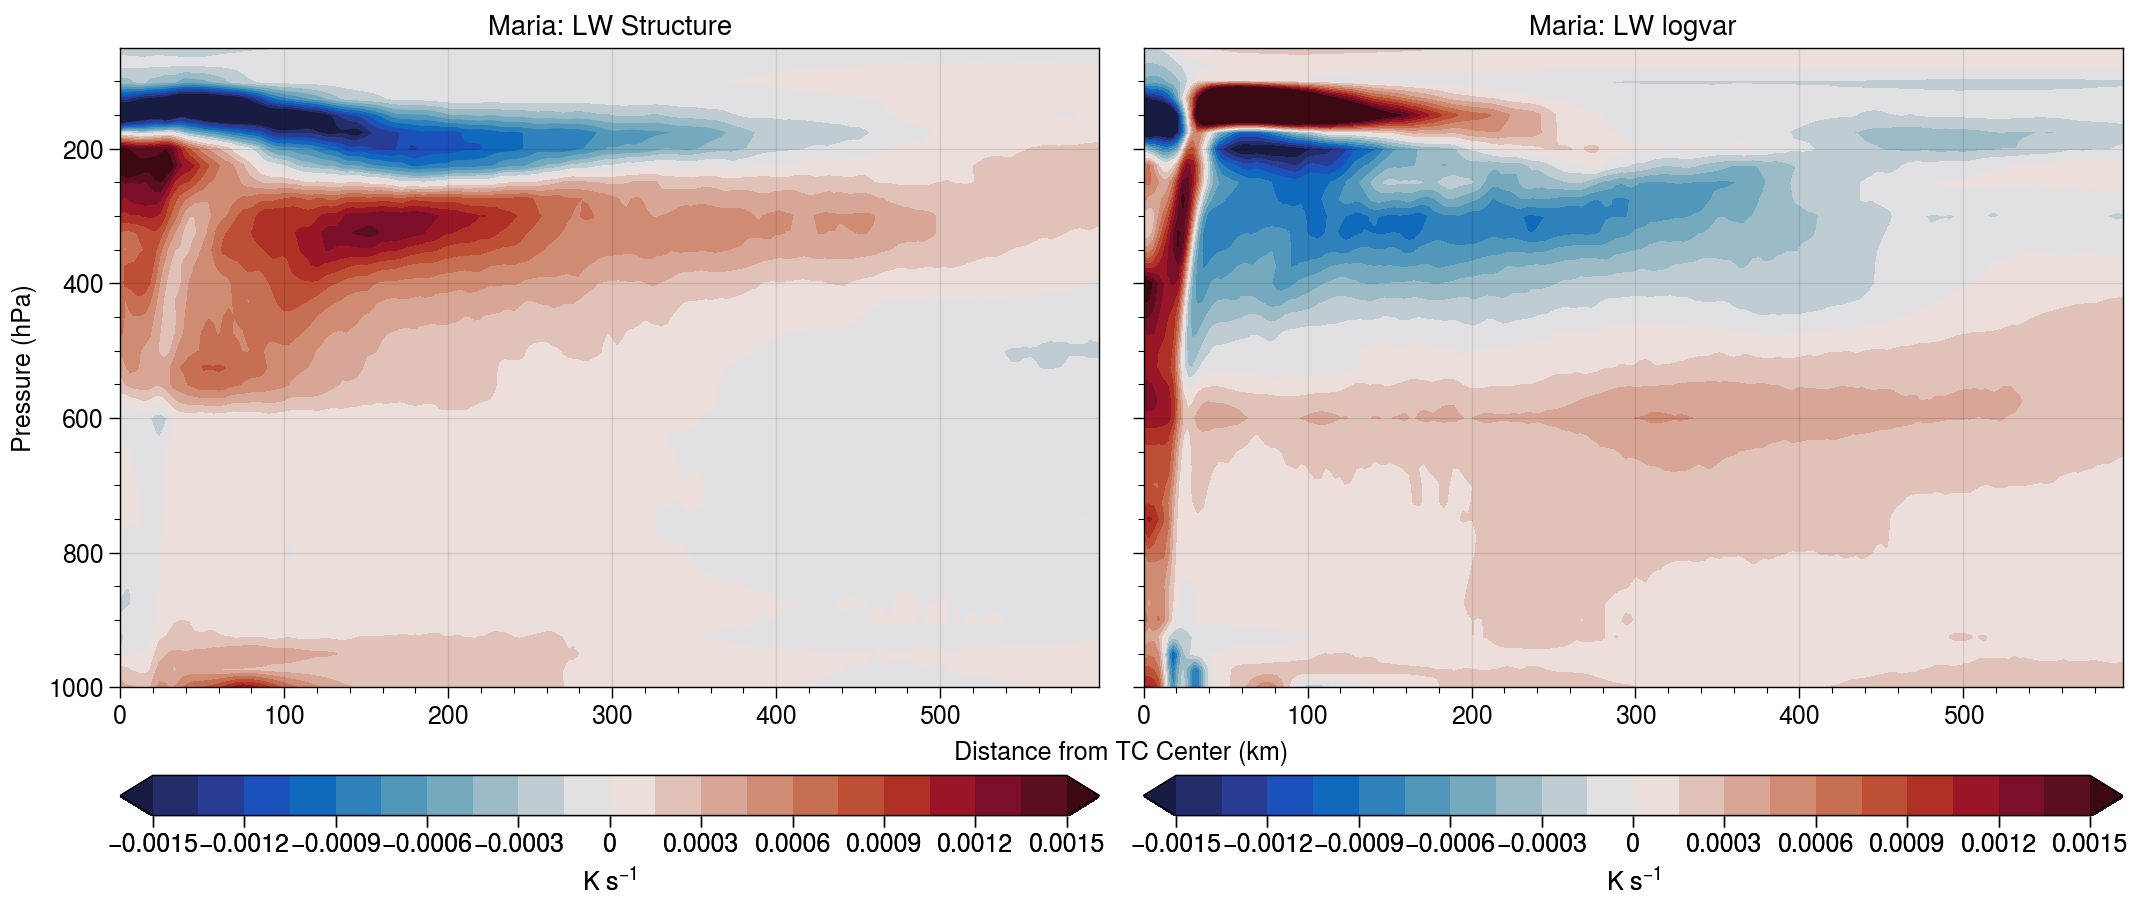

In [10]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.895,refaspect=1.531)
img = axs[0].contourf(np.linspace(0,flas.shape[2]-1,flas.shape[2])*3,(preslv),np.mean(flas,axis=1),cmap='balance',levels=np.linspace(-1.5e-3,1.5e-3,21),extend='both')#vmin=-0.5e-5,vmax=0.5e-5)
axs[0].colorbar(img,loc='b',label='K s$^{-1}$')
axs[0].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)',title='Maria: LW Structure')
img2 = axs[1].contourf(np.linspace(0,flas.shape[2]-1,flas.shape[2])*3,(preslv),np.mean(flas_logvar,axis=1),cmap='balance',levels=np.linspace(-1.5e-3,1.5e-3,21),extend='both')
axs[1].colorbar(img2,loc='b',label='K s$^{-1}$')
axs[1].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)',title='Maria: LW logvar')
plt.savefig('./figures/fig3_optimstructures2D_revised_maria.png',dpi=600)
plt.show()

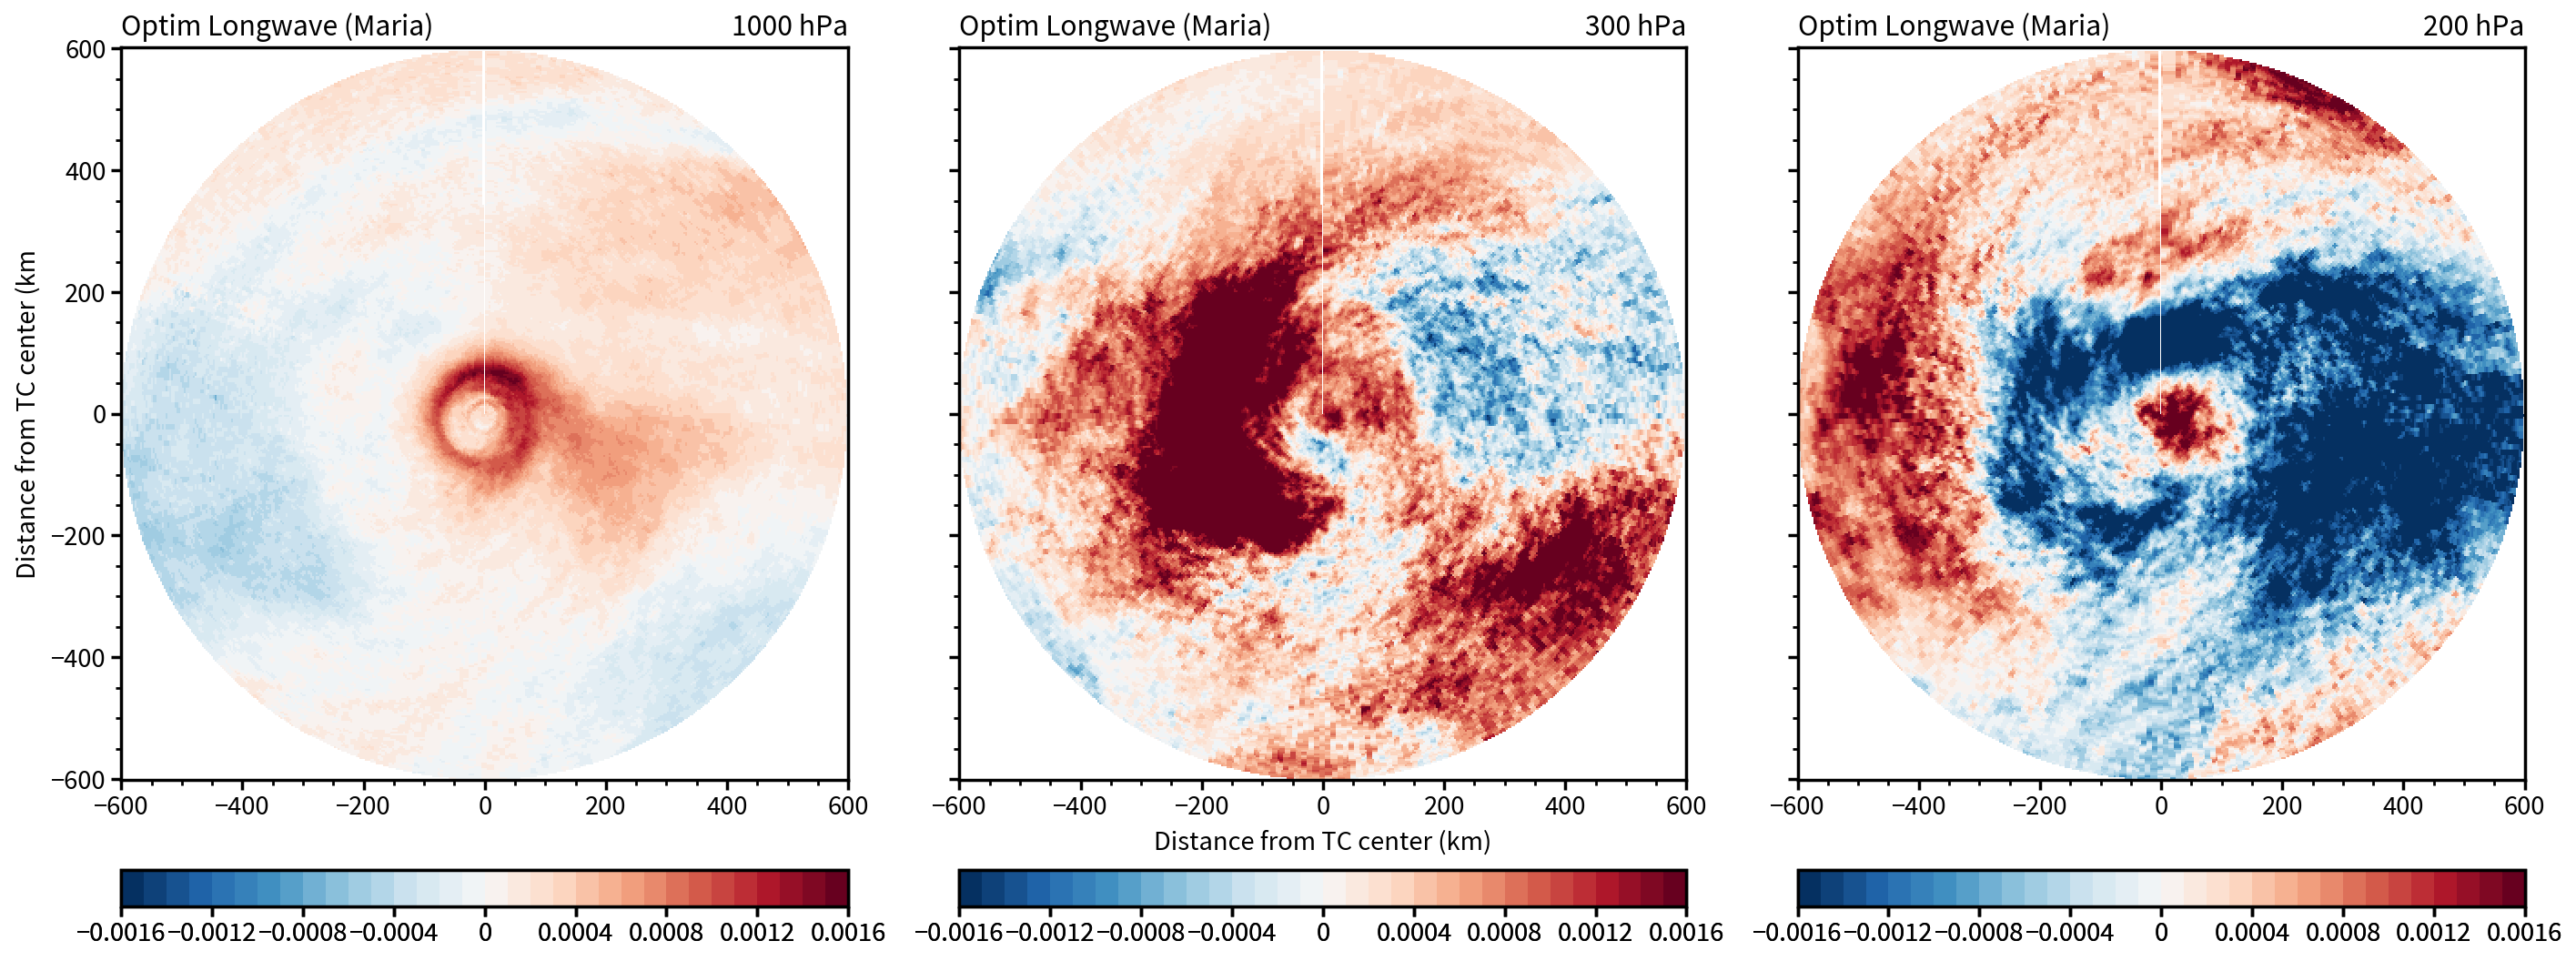

In [32]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
pressurelevel = [1000,300,200]
pressure_indx = [np.abs(preslv-obj).argmin() for obj in pressurelevel]

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.995,refaspect=0.9931)
for i,obj in enumerate(pressure_indx):
    #maps = axs[i].pcolormesh(np.ma.masked_inside(normalize(np.fliplr(np.flipud(read_and_proc.proc_tocart(optimLW[int(obj),...],ANGLE,True,False)))),-.65,.65),cmap='BuRd',vmin=-3,vmax=3)
    apl = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(flas)[obj,...],ANGLE,True,False))))
    values = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(flas)[obj,...],ANGLE,True,False))))[0,0]
    maps = axs[i].pcolormesh(np.linspace(-200,200,400)*3, np.linspace(-200,200,400)*3, np.ma.masked_where(apl==values,apl),cmap='BuRd',levels=np.linspace(-0.0016,0.0016,33))
    # hatches
    #stdd = np.nanstd(np.abs(np.asarray(test_toavg)[:,5,int(obj),...]))#,45)
    #aaaa = np.ma.masked_inside((np.fliplr(np.flipud(read_and_proc.proc_tocart(np.nanmean(np.asarray(test_toavg),axis=0)[5,int(obj),...],ANGLE,True,False)))),-stdd,stdd).mask
    #axs[i].contourf(aaaa.astype(int),levels=[0,0.5,1],hatches=["////","",""],alpha=0)
    # format
    axs[i].format(ltitle='Optim Longwave (Maria)',xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km',rtitle=f'{pressurelevel[i]} hPa',xlim=[-600,600])
    axs[i].colorbar(maps,loc='b')
#plt.savefig('./figures/optimstructures3D_revised_maria.png',dpi=600)
plt.show()

In [89]:
np.abs(preslv-800).argmin()

8

# Physical interpretation

In [13]:
import analysis

In [14]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
maria_lw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix+'_radcomp')['LW'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
start = [analysis.find_start(maria_lw,0,1),analysis.find_start(maria_lw,0,2),analysis.find_start(maria_lw,0,3),analysis.find_start(maria_lw,0,4)]
maria_lwa = analysis.long_MariaExps(maria_lw,start)

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
start

[25, 49, 85, 25]

In [16]:
[len(obj) for obj in maria_lwa]

[118, 120, 96, 60, 120]

## Uncertainty

In [20]:
calc_device='cpu'
class OptimMLR_lwsw_3D_ts_dropout_small_dropemulate(torch.nn.Module):
    def __init__(self,droprate,brchindices):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_lwsw_3D_ts_dropout_small_dropemulate, self).__init__()
        self.brchindices = brchindices
        ############################################################
        # Input channels
        ############################################################
        brchsize = self.brchindices[-2:]#[50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dropout1 = torch.nn.Dropout(droprate)
        self.dropout2 = torch.nn.Dropout(droprate)
        
    def forward(self,X):
        brchindex = list(np.asarray(self.brchindices).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        X_lwc = self.dropout1(X_lw)
        #bestlw = self.dense1(X_lwc)
        X_swc = self.dropout2(X_sw)
        #bestsw = self.dense2(X_swc)
        return X_lwc,X_swc
    
from copy import deepcopy
def get_MLdrop_structures(bestmodel=None,pcastore=None,standard=True,shape3D=[10,360,208],Xtest=None,ytest=None,dropout=0.1,brchindex=[0,50,26,50,50,50,10,10],compnums=[10,10]):
    # First Model
    model = OptimMLR_lwsw_3D_ts_dropout_small_dropemulate(dropout,brchindex)
    model_dict = model.state_dict()
    pretrained_dict = bestmodel.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    
    test_Xtensor = torch.FloatTensor(Xtest).to(calc_device)
    test_ytensor = torch.FloatTensor(ytest).to(calc_device)
    lwdrop,swdrop = model.train()(test_Xtensor)
    lwdrop,swdrop = lwdrop.detach().numpy(),swdrop.detach().numpy()
    weights = benchmark.model_outweights(model)
    
    normpattern_SW,normpattern_LW,weightsstore = [],[],[]
    for i in range(len(lwdrop)):
        LWweights = deepcopy(weights[0][0].detach().numpy())
        SWweights = deepcopy(weights[0][1].detach().numpy())
        LW_zeroindices,SW_zeroindices = list(np.where(lwdrop[i,...]==0)[0]),list(np.where(swdrop[i,...]==0)[0])
        np.put(LWweights,LW_zeroindices,[0 for _ in range(len(LW_zeroindices))])
        np.put(SWweights,SW_zeroindices,[0 for _ in range(len(SW_zeroindices))])
        weightsstore.append({'LW':LWweights,'SW':SWweights})
        
        if standard:
            TEST_LW = (LWweights)/((np.sqrt(np.sum(LWweights**2))))
            TEST_SW = (SWweights)/((np.sqrt(np.sum(SWweights**2))))
            normpattern_SW.append(np.squeeze(np.dot(TEST_SW,pcastore['sw'].components_[:compnums[0],:])).reshape(shape3D[0],shape3D[1],shape3D[2]))
            normpattern_LW.append(np.squeeze(np.dot(TEST_LW,pcastore['lw'].components_[:compnums[1],:])).reshape(shape3D[0],shape3D[1],shape3D[2]))
    return normpattern_LW,normpattern_SW,weightsstore

## Wind Shear

In [22]:
import analysis
maria_u = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['u'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
maria_v = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['v'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
start = [analysis.find_start(maria_lw,0,1),analysis.find_start(maria_lw,0,2),analysis.find_start(maria_lw,0,3),analysis.find_start(maria_lw,0,4)]
maria_lwa = analysis.long_MariaExps(maria_lw,start)
maria_ua,maria_va = analysis.long_MariaExps(maria_u,start),analysis.long_MariaExps(maria_v,start)

maria_qv = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['qv'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
maria_qva = analysis.long_MariaExps(maria_qv,start)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [52]:
from metpy.calc import wind_direction
from metpy.units import units

def give_meanquadrants(array=None,sheardir=None,ANGLE=read_and_proc.azimuth2angle(np.linspace(0,359,360))): #np.std(np.asarray(numnum)[:],axis=0)
    pressurelevel = [1000,600,200]
    pressure_indx = [np.abs(preslv-obj).argmin() for obj in pressurelevel]
        
    PWnew = [np.asarray(array)[int(np.abs(ANGLE-360).argmin()),:]]
    for i in np.linspace(0,358,359):
        PWnew.append(np.asarray(array)[int(np.abs(ANGLE-i).argmin()),:])
    PWnew = np.asarray(PWnew)#np.swapaxes(np.asarray(PWnew),0,1)
    
    DWR_in = (np.mean(PWnew[int(sheardir):int(sheardir)+90,0:67]))
    DWR_out = (np.mean(PWnew[int(sheardir):int(sheardir)+90,67:]))
    DWL_in = (np.mean(PWnew[int(sheardir)-90:int(sheardir),0:67]))
    DWL_out = (np.mean(PWnew[int(sheardir)-90:int(sheardir),67:]))
    UWR_in = (np.mean(PWnew[int(sheardir)+90:int(sheardir)+180,0:67]))
    UWR_out = (np.mean(PWnew[int(sheardir)+90:int(sheardir)+180,67:]))
    UWL_in = (np.mean(PWnew[int(sheardir)+180:int(sheardir)+270,0:67]))
    UWL_out = (np.mean(PWnew[int(sheardir)+180:int(sheardir)+270,67:]))
    return DWR_in,DWR_out,DWL_in,DWL_out,UWR_in,UWR_out,UWL_in,UWL_out

def give_quadrants(array=None,sheardir=None,ANGLE=read_and_proc.azimuth2angle(np.linspace(0,359,360))): #np.std(np.asarray(numnum)[:],axis=0)
    pressurelevel = [1000,600,200]
    pressure_indx = [np.abs(preslv-obj).argmin() for obj in pressurelevel]
        
    PWnew = [np.asarray(array)[int(np.abs(ANGLE-360).argmin()),:]]
    for i in np.linspace(0,358,359):
        PWnew.append(np.asarray(array)[int(np.abs(ANGLE-i).argmin()),:])
    PWnew = np.asarray(PWnew)#np.swapaxes(np.asarray(PWnew),0,1)
    
    DWR_in = ((PWnew[int(sheardir):int(sheardir)+90,0:67]))
    DWR_out = ((PWnew[int(sheardir):int(sheardir)+90,67:]))
    DWL_in = ((PWnew[int(sheardir)-90:int(sheardir),0:67]))
    DWL_out = ((PWnew[int(sheardir)-90:int(sheardir),67:]))
    UWR_in = ((PWnew[int(sheardir)+90:int(sheardir)+180,0:67]))
    UWR_out = ((PWnew[int(sheardir)+90:int(sheardir)+180,67:]))
    UWL_in = ((PWnew[int(sheardir)+180:int(sheardir)+270,0:67]))
    UWL_out = ((PWnew[int(sheardir)+180:int(sheardir)+270,67:]))
    return DWR_in,DWR_out,DWL_in,DWL_out,UWR_in,UWR_out,UWL_in,UWL_out

def give_quadrants_env(array=None,sheardir=None,ANGLE=read_and_proc.azimuth2angle(np.linspace(0,359,360)),mean=True): #np.std(np.asarray(numnum)[:],axis=0)
    PWnew = [np.asarray(array)[int(np.abs(ANGLE-360).argmin()),:]]
    for i in np.linspace(0,358,359):
        PWnew.append(np.asarray(array)[int(np.abs(ANGLE-i).argmin()),:])
    PWnew = np.asarray(PWnew)#np.swapaxes(np.asarray(PWnew),0,1)
    
    if mean:
        DWR_in = np.mean((PWnew[int(sheardir):int(sheardir)+90,0:67]))
        DWR_out = np.mean((PWnew[int(sheardir):int(sheardir)+90,67:]))
        DWL_in = np.mean((PWnew[int(sheardir)-90:int(sheardir),0:67]))
        DWL_out = np.mean((PWnew[int(sheardir)-90:int(sheardir),67:]))
        UWR_in = np.mean((PWnew[int(sheardir)+90:int(sheardir)+180,0:67]))
        UWR_out = np.mean((PWnew[int(sheardir)+90:int(sheardir)+180,67:]))
        UWL_in = np.mean((PWnew[int(sheardir)+180:int(sheardir)+270,0:67]))
        UWL_out = np.mean((PWnew[int(sheardir)+180:int(sheardir)+270,67:]))
    else:
        DWR_in = ((PWnew[int(sheardir):int(sheardir)+90,0:67]))
        DWR_out = ((PWnew[int(sheardir):int(sheardir)+90,67:]))
        DWL_in = ((PWnew[int(sheardir)-90:int(sheardir),0:67]))
        DWL_out = ((PWnew[int(sheardir)-90:int(sheardir),67:]))
        UWR_in = ((PWnew[int(sheardir)+90:int(sheardir)+180,0:67]))
        UWR_out = ((PWnew[int(sheardir)+90:int(sheardir)+180,67:]))
        UWL_in = ((PWnew[int(sheardir)+180:int(sheardir)+270,0:67]))
        UWL_out = ((PWnew[int(sheardir)+180:int(sheardir)+270,67:]))        
    return DWR_in,DWR_out,DWL_in,DWL_out,UWR_in,UWR_out,UWL_in,UWL_out

In [24]:
mariaUA,mariaVA = maria_ua[0].reshape(118,39,360,200),maria_va[0].reshape(118,39,360,200)
sheardir = []
for i in range(mariaUA.shape[0]):
    du,dv = mariaUA[i,32,...]-mariaUA[i,6,...], mariaVA[i,32,...]-mariaVA[i,6,...]
    dus,dvs = np.nanmean(du[...,67:]),np.nanmean(dv[...,67:])
    sheardir.append(float(wind_direction(dus*units('m/s'), dvs*units('m/s'), convention='to').magnitude))

In [27]:
DWR_in,DWR_out = [],[]
DWL_in,DWL_out = [],[]
UWR_in,UWR_out = [],[]
UWL_in,UWL_out = [],[]

pressurelevel = [1000,600,200]
pressure_indx = [np.abs(preslv-obj).argmin() for obj in pressurelevel]

for i in tqdm(range(mariaUA.shape[0]-24)):
    numnum = [np.asarray(LWstructures[i])[i,pressure_indx[1],...] for i in range(10)]
    DWR_inT,DWR_outT,DWL_inT,DWL_outT,UWR_inT,UWR_outT,UWL_inT,UWL_outT = give_meanquadrants(array=np.std(np.asarray(numnum)[:],axis=0),sheardir=sheardir[i],ANGLE=read_and_proc.azimuth2angle(np.linspace(0,359,360)))
    DWR_in.append(DWR_inT)
    DWR_out.append(DWR_outT)
    DWL_in.append(DWL_inT)
    DWL_out.append(DWL_outT)
    UWR_in.append(UWR_inT)
    UWR_out.append(UWR_outT)
    UWL_in.append(UWL_inT)
    UWL_out.append(UWL_outT)
    del numnum
    gc.collect()
    
IN = [np.asarray(obj).mean() for obj in [DWR_in,DWL_in,UWR_in,UWL_in]]
OUT = [np.asarray(obj).mean() for obj in [DWR_out,DWL_out,UWR_out,UWL_out]]
index = ['DWR','DWL','UWR','UWL']
df = pd.DataFrame({'0-200km': IN,'200-600km': OUT}, index=index)

  0%|          | 0/94 [00:00<?, ?it/s]

In [28]:
DWR_in_array,DWR_out_array = [],[]
DWL_in_array,DWL_out_array = [],[]
UWR_in_array,UWR_out_array = [],[]
UWL_in_array,UWL_out_array = [],[]

pressurelevel = [1000,600,200]
pressure_indx = [np.abs(preslv-obj).argmin() for obj in pressurelevel]

for i in tqdm(range(mariaUA.shape[0]-24)):
    numnum = [np.asarray(LWstructures[i])[i,pressure_indx[1],...] for i in range(10)]
    DWR_inT,DWR_outT,DWL_inT,DWL_outT,UWR_inT,UWR_outT,UWL_inT,UWL_outT = give_quadrants(array=np.std(np.asarray(numnum)[:],axis=0),sheardir=sheardir[i],ANGLE=read_and_proc.azimuth2angle(np.linspace(0,359,360)))
    DWR_in_array.append(DWR_inT)
    DWR_out_array.append(DWR_outT)
    DWL_in_array.append(DWL_inT)
    DWL_out_array.append(DWL_outT)
    UWR_in_array.append(UWR_inT)
    UWR_out_array.append(UWR_outT)
    UWL_in_array.append(UWL_inT)
    UWL_out_array.append(UWL_outT)
    del numnum
    gc.collect()

  0%|          | 0/94 [00:00<?, ?it/s]

In [86]:
ctrlqv = maria_qva[0].reshape(118,39,360,200)
ncrf36qv = maria_qva[1].reshape(120,39,360,200)
def give_quadrant_profile(array=None,sheardir=None,ANGLE=read_and_proc.azimuth2angle(np.linspace(0,359,360)),mean=True):
    storeDWR_in,storeDWR_out = [],[]
    storeDWL_in,storeDWL_out = [],[]
    storeUWR_in,storeUWR_out = [],[]
    storeUWL_in,storeUWL_out = [],[]
    for i in range((array.shape[1])):
        arrayf = array[:,i,...]
        
        storeDWR_in_t,storeDWR_out_t = [],[]
        storeDWL_in_t,storeDWL_out_t = [],[]
        storeUWR_in_t,storeUWR_out_t = [],[]
        storeUWL_in_t,storeUWL_out_t = [],[]
        for j in range((array.shape[0])):
            DWR_in,DWR_out,DWL_in,DWL_out,UWR_in,UWR_out,UWL_in,UWL_out = give_quadrants_env(array=arrayf[j,...],sheardir=sheardir[i],ANGLE=ANGLE,mean=mean)
            storeDWR_in_t.append(DWR_in)
            storeDWR_out_t.append(DWR_out)
            storeDWL_in_t.append(DWL_in)
            storeDWL_out_t.append(DWL_out)
            storeUWR_in_t.append(UWR_in)
            storeUWR_out_t.append(UWR_out)
            storeUWL_in_t.append(UWL_in)
            storeUWL_out_t.append(UWL_out)
        storeDWR_in.append(storeDWR_in_t)
        storeDWR_out.append(storeDWR_out_t)
        storeDWL_in.append(storeDWL_in_t)
        storeDWL_out.append(storeDWL_out_t)
        storeUWL_in.append(storeUWL_in_t)
        storeUWL_out.append(storeUWL_out_t)
        storeUWR_in.append(storeUWR_in_t)
        storeUWR_out.append(storeUWR_out_t)
    return np.swapaxes(np.asarray(storeDWR_in),0,1),np.swapaxes(np.asarray(storeDWR_out),0,1),np.swapaxes(np.asarray(storeDWL_in),0,1),np.swapaxes(np.asarray(storeDWL_out),0,1),\
np.swapaxes(np.asarray(storeUWR_in),0,1),np.swapaxes(np.asarray(storeUWR_out),0,1),np.swapaxes(np.asarray(storeUWL_in),0,1),np.swapaxes(np.asarray(storeUWL_out),0,1)